In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data=pd.read_csv('2011fe_photometry.csv')

In [3]:
data['band'].unique()

array(['g', "g'", 'UVW1', 'U', 'B', 'UVW2', 'V', 'UVM2', 'I', 'R', 'r',
       'Rc', 'Ic', 'H', 'K', 'J', '1', '2', 'I1', 'I2'], dtype=object)

In [4]:
band=data[data['band']=='B']
band=band[band['e_magnitude']<=0.1]

#band['source'].unique()

#band=band[band['source']=='2013CoSka..43...94T,Sternberg Astronomical Institute Supernova Light Curve Catalogue']

In [5]:
band

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
105,SN2011fe,55797.9261,15.585,0.052,F,B,UVOT,Swift,2014Ap&SS.354...89B
111,SN2011fe,55797.9930,15.427,0.048,F,B,UVOT,Swift,2014Ap&SS.354...89B
116,SN2011fe,55798.1700,15.206,0.016,F,B,NaN,kait4,2012MNRAS.425.1789S
129,SN2011fe,55798.8500,14.330,0.030,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
133,SN2011fe,55798.8800,14.360,0.030,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
...,...,...,...,...,...,...,...,...,...
3378,SN2011fe,56152.8000,17.920,0.080,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3391,SN2011fe,56154.7600,17.690,0.050,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3446,SN2011fe,56193.7300,18.160,0.050,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."
3451,SN2011fe,56198.7000,18.300,0.080,F,B,NaN,NaN,"2013CoSka..43...94T,Sternberg Astronomical Ins..."


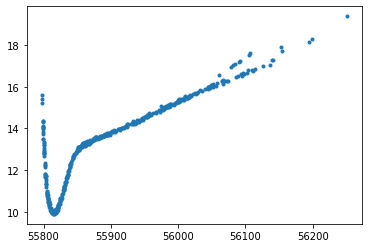

In [6]:
plt.scatter(band['time'],band['magnitude'],marker='.')


In [7]:

from george.modeling import Model
class MeanModel(Model):
    parameter_names=('a1','b1','c1','a2','b2','c2','tsep')
    
    def get_value(self,t):
        flux=np.zeros(len(t))
        
        ind =np.argmin(np.abs(t-self.tsep))
        
        flux[0:ind]=self.a1*t[0:ind]**2+self.b1*t[0:ind]+self.c1
        flux[ind:]=self.a2*t[ind:]**2+self.b2*t[ind:]+self.c2
        
        return flux

In [8]:
from george import kernels

kernel=kernels.ExpSquaredKernel(50.0)


In [9]:
np.argmin(np.abs(band['time']-55840))

166

In [10]:
a10,b10,c10=np.polyfit(band['time'][0:165],band['magnitude'][0:165],deg=2)

In [11]:
a20,b20,c20=np.polyfit(band['time'][165:],band['magnitude'][165:],deg=2)

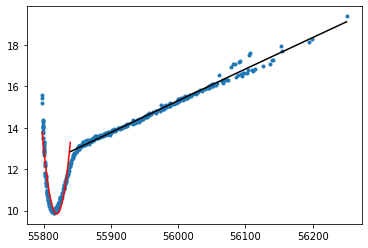

In [12]:
plt.scatter(band['time'],band['magnitude'],marker='.')

plt.plot(band['time'][0:165],a10*band['time'][0:165]**2+b10*band['time'][0:165]+c10,'r')

plt.plot(band['time'][165:],a20*band['time'][165:]**2+b20*band['time'][165:]+c20,'k')

In [13]:
def lnprob(p):
    model.set_parameter_vector(p) 
    return -model.lnlikelihood(band["magnitude"], quiet=True)

In [14]:
import scipy.optimize as op
import george
#model = george.GP(kernel=kernel,mean=m0)
global model

tsep0=55840

model = george.GP(kernel = kernel, mean = MeanModel(a10,b10,c10,a20,b20,c20,tsep0))

model.compute(band["time"])

p0 = model.get_parameter_vector()
results = op.minimize(lnprob, p0, method="L-BFGS-B")

t_new = np.linspace(np.min(band['time']),np.max(band['time']), len(band['time']))

ypred,cov= model.predict(band['magnitude'], t_new)


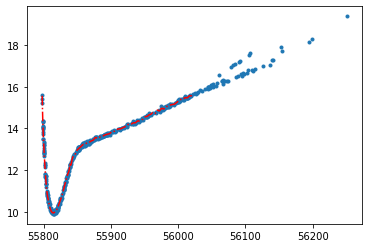

In [15]:
plt.plot(t_new[0:250],ypred[0:250],c='r',ls='-.')
plt.scatter(band['time'],band['magnitude'],marker='.')

In [18]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt

In [21]:
time = band['time']
mag = band['magnitude']

In [32]:
class MeanModel(pm.gp.mean.Mean):
    def __init__(self, a1, b1, c1, a2, b2, c2, tsep):
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2
        self.tsep = tsep
    def __call__(self, t):
        
        ind=np.argmin(np.abs(t-self.tsep))
        
        rtime = t[t <= ind]
        dtime = t[t > ind]
        rise = self.a1*rtime**2 + self.b1*rtime + self.c1
        decline = self.a2*dtime**2 + self.b2*dtime + self.c2
        mean = tt.concatenate([rise, decline])
        return mean

In [33]:
with pm.Model() as marginal_gp_model:
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=10.0)
    
    a11 = pm.Normal('a1', a10, sigma=0.1*a10, shape=1)
    b11 = pm.Normal('b1', b10, sigma=0.1*b10, shape=1)
    c11 = pm.Normal('c1', c10, sigma=0.1*c10, shape=1)
    a21 = pm.Normal('a2', a20, sigma=0.1*a20, shape=1)
    b21 = pm.Normal('b2', b20, sigma=0.1*b20, shape=1)
    c21 = pm.Normal('c2', c20, sigma=0.1*c20, shape=1)
    tsep1 = pm.Normal('tsep', tsep0, sigma=10, shape=1)

    mean_func = MeanModel(a1=a11, b1=b11, c1=c11, a2=a21, b2=b21, c2=c21, tsep=tsep1)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("mag", X=time[:, None], y=mag, noise=0.1)
    mp = pm.find_MAP()

/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/thirty-oner/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

In [39]:
# new values from x=0 to x=100
X_new = np.linspace(np.min(time), np.max(time), 400)[:, None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=50)

ValueError: length not known: Elemwise{sub,no_inplace} [id A] ''   
 |TensorConstant{[15.585 15..   19.38 ]} [id B]
 |Join [id C] ''   
   |TensorConstant{0} [id D]
   |Elemwise{add,no_inplace} [id E] ''   
   | |Elemwise{add,no_inplace} [id F] ''   
   | | |Elemwise{mul,no_inplace} [id G] ''   
   | | | |a1 [id H]
   | | | |TensorConstant{[]} [id I]
   | | |Elemwise{mul,no_inplace} [id J] ''   
   | |   |b1 [id K]
   | |   |TensorConstant{[]} [id L]
   | |c1 [id M]
   |Elemwise{add,no_inplace} [id N] ''   
     |Elemwise{add,no_inplace} [id O] ''   
     | |Elemwise{mul,no_inplace} [id P] ''   
     | | |a2 [id Q]
     | | |TensorConstant{[3.1134085..07488e+09]} [id R]
     | |Elemwise{mul,no_inplace} [id S] ''   
     |   |b2 [id T]
     |   |TensorConstant{[55797.926..6250.11  ]} [id U]
     |c2 [id V]
